In [1]:
import torch

In [2]:
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import random
from scipy.io import loadmat
from os import listdir
import torch.optim as optim

import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import math

from torchvision import models

In [3]:
from apex import amp

In [4]:
from tqdm.notebook import tqdm

In [5]:
torch.backends.cudnn.benchmark = True #might make it a tiny bit faster

In [6]:
DATA_160 = Path("/data1/datasets/160")
DATA = Path("/data1/datasets/320")

In [7]:
PATH = Path("/data2/yinterian/imagenet_exp")

In [8]:
#resnet = models.resnet18(pretrained=True)
#layers = list(resnet.children())[:8]

In [9]:
def basicblock(in_, out_, kernel_size=3, stride=1, dilation=1, groups=1):
    padding = kernel_size//2
    block = nn.Sequential(nn.Conv2d(in_, out_, kernel_size, stride, padding, groups=groups, bias=False),
                          nn.BatchNorm2d(out_))    
    return block

In [10]:
class mainblock(nn.Module): 
    
    def __init__(self, in_, out_):  
        super(mainblock, self).__init__()
        self.apply_shortcut = not (in_ == out_)
        stride = 1
        if self.apply_shortcut:
            self.shortcut = basicblock(in_, out_, 1, 2)
            stride = 2
            
        self.layers = nn.Sequential(basicblock(in_, out_, 3, stride),
                                    nn.ReLU(inplace=True),
                                    basicblock(out_, out_, 3, 1)) 
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):     
        if self.apply_shortcut: 
            return self.relu(self.shortcut(x) + self.layers(x))
        else: 
            return self.relu(x + self.layers(x))

### Depthwise separable block

In [11]:
class depthwise_block(nn.Module):
    
    def __init__(self, in_, out_, activation=nn.ReLU):
        
        super(depthwise_block, self).__init__()
        self.apply_shortcut = not (in_ == out_)
        stride = 1
        if self.apply_shortcut:
            self.shortcut = basicblock(in_, out_, 1, 2)
            stride = 2 
        self.relu = nn.ReLU(inplace=True)
        self.layers = nn.Sequential(basicblock(in_, out_, 3, stride, groups=in_),
                                    activation(inplace=True),
                                    basicblock(out_, out_, 1))
        
    def forward(self, x):
        if self.apply_shortcut: 
            return self.relu(self.shortcut(x) + self.layers(x))
        else: 
            return self.relu(x + self.layers(x))

In [12]:
class resnet18(nn.Module): 
    def __init__(self, block=mainblock, num_classes=1000):
        
        super(resnet18, self).__init__()
        self.features1 = nn.Sequential(basicblock(3, 64, 7, 2),
                                       nn.ReLU(inplace=True), 
                                       nn.MaxPool2d(3, 2, 1), 
                                       block(64, 64),
                                       block(64, 64),
                                       block(64, 128),
                                       block(128, 128))
        self.features2 = nn.Sequential(block(128, 256),
                                       block(256, 256),
                                       block(256, 512),
                                       block(512, 512))
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

## Data

In [13]:
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, rand_r, start_c, nr=300, nc=300):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    r_pix = (r - nr)//2
    c_pix = (c - nc)//2
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, nr, nc)

def center_crop(x, nr=300, nc=300):
    r, c,*_ = x.shape
    r_pix = (r - nr)//2
    c_pix = (c - nc)//2
    return crop(x, r_pix, c_pix, nr, nc)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [14]:
train_df = pd.read_csv(DATA/"train.csv")
valid_df = pd.read_csv(DATA/"valid.csv")

In [15]:
valid_df.head()

,x,y
0,val/n07754684/ILSVRC2012_val_00004497.JPEG,n07754684
1,val/n07754684/ILSVRC2012_val_00048298.JPEG,n07754684
2,val/n07754684/ILSVRC2012_val_00003664.JPEG,n07754684
3,val/n07754684/ILSVRC2012_val_00008662.JPEG,n07754684
4,val/n07754684/ILSVRC2012_val_00007563.JPEG,n07754684


In [16]:
path = DATA/train_df["x"][8]
path

PosixPath('/data1/datasets/320/train/n07754684/n07754684_12485.JPEG')

In [17]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

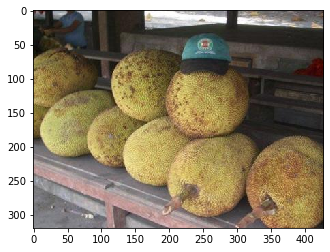

In [18]:
im = read_image(path)
plt.imshow(im)

(300, 300, 3)

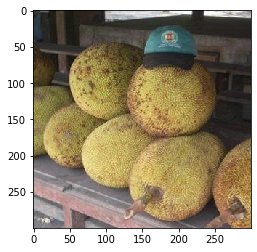

In [19]:
rand_r = random.uniform(0, 1)
rand_c = random.uniform(0, 1)
im2 = random_crop(im, rand_r, rand_c)
plt.imshow(im2); im2.shape

(300, 300, 3)

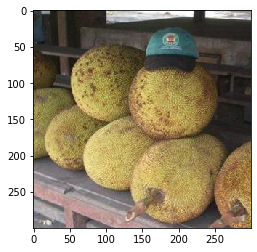

In [20]:
im2 = center_crop(im)
plt.imshow(im2); im2.shape

## Dataset

In [21]:
classes = np.sort(train_df["y"].unique())
class2id ={v:k for k,v in enumerate(classes)}

In [22]:
def apply_transforms(x, rand_arr, nr, nc):
    """ Applies a random crop, rotation"""
    rdeg = (rand_arr[0] -.50)*10
    x = rotate_cv(x, rdeg)
    if rand_arr[1] > 0.5: x = np.fliplr(x).copy() 
    x = random_crop(x, rand_arr[2], rand_arr[3], nr, nc)
    return x

In [23]:
class ImageNetDataSet(Dataset):
    def __init__(self, df, nr=300, transform=None):
        """
        Args:
            dataframe with data: image_file, label
            transform: if True apply transforms to images
        """
        self.image_files = df["x"].values
        self.labels = [class2id[y] for y in df["y"].values]
        self.transform = transform
        self.len = len(self.image_files)
        self.random_init()
        self.nr=nr
        
    def random_init(self):
        self.random = np.random.rand(self.len, 4)

    def __getitem__(self, index):
        path = DATA/self.image_files[index]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            x = apply_transforms(x, self.random[index], nr=self.nr, nc=self.nr)
        else:
            x = center_crop(x, nr=self.nr, nc=self.nr)
            
        y = self.labels[index]
        return np.rollaxis(x, 2), y

    def __len__(self):
        return self.len

In [24]:
train_df = pd.read_csv(DATA/"train.csv")
valid_df = pd.read_csv(DATA/"valid.csv")
train_ds = ImageNetDataSet(train_df, transform=True)
valid_ds = ImageNetDataSet(valid_df)

In [25]:
def normalize_tensors(x, y):
    # normalized 
    mean = torch.tensor([0.485 * 255, 0.456 * 255, 0.406 * 255]).cuda().view(1,3,1,1).half()
    std = torch.tensor([0.229 * 255, 0.224 * 255, 0.225 * 255]).cuda().view(1,3,1,1).half()
    x = x.half().cuda(non_blocking=True)
    return x.sub_(mean).div_(std), y.cuda(non_blocking=True)

## Training 

In [26]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [27]:
def LR_range_finder(model, optimizer, train_ds, train_dl, lr_low=1e-4, lr_high=0.1, epochs=1):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    pbar = tqdm(total=iterations)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    prev_loss = 0
    for i in range(epochs):
        train_ds.random_init()
        for x,y in train_dl:
            lr = lrs[ind]
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            x, y = normalize_tensors(x, y)
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
            optimizer.step()
            losses.append((prev_loss + loss.item())/2)
            prev_loss = loss.item()
            ind +=1
            pbar.update()
            
    load_model(model, str(p))
    return lrs[1:], losses[1:]

In [28]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/10, max_lr/100
    iter1 = int(0.2*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

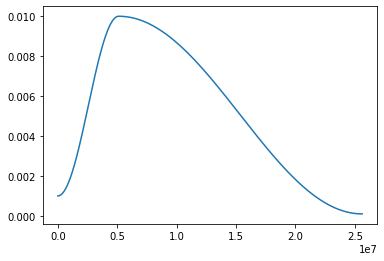

In [29]:
N = len(train_ds)*20
lr = get_cosine_triangular_lr(0.01, N)
plt.plot(list(range(N)), lr)
plt.show()

In [30]:
def val_metric(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in valid_dl:
            x, y = normalize_tensors(x, y)
            batch = y.shape[0]
            out = model(x)
            pred = torch.max(out, 1)[1]
            loss = F.cross_entropy(out, y)
            sum_loss += batch*(loss.item())
            total += batch
            correct += (pred == y).float().sum().item()
    
    return sum_loss/total, correct/total

In [31]:
def train_epoch(model, train_ds, train_dl, optimizer, lrs, idx, epoch, pbar):
    model.train()
    train_ds.random_init()
    total = 0
    sum_loss = 0
    for x,y in train_dl:
        lr = lrs[idx]
           
        update_optimizer(optimizer, [lr/4, lr/2, lr])
        x, y = normalize_tensors(x, y)
        batch = y.shape[0]
        out = model(x)
        loss = F.cross_entropy(out, y)
        optimizer.zero_grad()
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        #loss.backward()
        optimizer.step()
        pbar.update()
        idx += 1
        total += batch
        sum_loss += batch*(loss.item())
    train_loss = sum_loss/total
    return train_loss, idx 

In [32]:
def train_a_few_epocs(model, optimizer, train_ds, train_dl, valid_dl, max_lr, epochs = 60, fixed_lr=False):
    
    iterations = epochs*len(train_dl)
    pbar = tqdm(total=iterations)
    best_val_acc = 0.0
    idx = 0
    
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    if fixed_lr:
        lrs = [max_lr for i in range(iterations)]
    for i in range(epochs):
        print("using lr ", i, lrs[idx], idx)
        train_loss, idx = train_epoch(model, train_ds, train_dl, optimizer, lrs, idx, i, pbar)
        val_loss, val_acc = val_metric(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f \n" % 
              (train_loss, val_loss, val_acc))
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            path = "{0}/models/model_imagenet4_acc_{1:.0f}.pth".format(PATH, 100*val_acc) 
            save_model(model, path)
            print(path)

In [33]:
def create_optimizer(model, lr):
    params = [{'params': model.features1.parameters(), 'lr': lr},
              {'params': model.features2.parameters(), 'lr': lr},
              {'params': model.classifier.parameters(), 'lr': lr}]
    return optim.Adam(params, weight_decay=1e-5) # try 1e-4

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [34]:
model = resnet18().cuda()

In [35]:
load_model(model, "/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_68.pth")

In [36]:
optimizer = create_optimizer(model, 0.001)
model, optimizer = amp.initialize(model, optimizer, opt_level="O2", 
                                      keep_batchnorm_fp32=True, loss_scale="dynamic")

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


In [37]:
batch_size = 700
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=10)
valid_dl = DataLoader(valid_ds, batch_size=batch_size//5, pin_memory=True, num_workers=10)

In [38]:
train_a_few_epocs(model, optimizer, train_ds, train_dl, valid_dl, max_lr=0.0005, epochs = 5, fixed_lr=True)

using lr  0 0.0005 0
train_loss 0.798 val_loss 1.379 val_acc 0.671 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_67.pth
using lr  1 0.0005 1831
train_loss 0.783 val_loss 1.384 val_acc 0.669 

using lr  2 0.0005 3662
train_loss 0.768 val_loss 1.392 val_acc 0.669 

using lr  3 0.0005 5493
train_loss 0.755 val_loss 1.408 val_acc 0.665 

using lr  4 0.0005 7324
train_loss 0.741 val_loss 1.418 val_acc 0.663 



In [38]:
train_a_few_epocs(model, optimizer, train_ds, train_dl, valid_dl, max_lr=0.01, epochs = 25)

using lr  0 0.0009999999999999992 0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
train_loss 4.401 val_loss 3.779 val_acc 0.228 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_23.pth
using lr  1 0.001859423525312735 1831
train_loss 2.907 val_loss 3.129 val_acc 0.330 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_33.pth
using lr  2 0.004109423525312736 3662
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0
train_loss 2.414 val_loss 2.703 val_acc 0.405 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_41.pth
using lr  3 0.006890576474687264 5493
train_loss 2.226 val_loss 2.775 val_acc 0.394 

using lr  4 0.009140576474687263 7324
train_loss 2.139 val_loss 2.480 val_acc 0.441 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_44.pth
using lr  5 0.01 9155
train_loss 2.057 val_loss 2.387 val_acc 0.462 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_46.pth
using lr  6 0.00993905

## with 2 epochs of warm up

In [48]:
train_a_few_epocs(model, optimizer, train_ds, train_dl, valid_dl, max_lr=0.02, epochs = 20)

using lr  0 0.0010000000000000009 0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
train_loss 4.503 val_loss 3.797 val_acc 0.228 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_23.pth
using lr  1 0.0037824855787278004 1831
train_loss 2.965 val_loss 3.586 val_acc 0.264 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_26.pth
using lr  2 0.0105 3662
train_loss 2.339 val_loss 2.654 val_acc 0.409 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_41.pth
using lr  3 0.0172175144212722 5493
train_loss 2.297 val_loss 2.655 val_acc 0.411 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_41.pth
using lr  4 0.02 7324
train_loss 2.239 val_loss 2.613 val_acc 0.419 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_42.pth
using lr  5 0.01980977427599198 9155
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 524288.0
train_loss 2.178 val_loss 2.592 val_acc 0.428 

/data2/yinterian/imagenet_exp/models/

## with a lower start and 
[lr/9, lr/3, lr]

In [40]:
train_a_few_epocs(model, optimizer, train_ds, train_dl, valid_dl, max_lr=0.02, epochs = 20)

using lr  0 0.0010000000000000009 0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
train_loss 4.469 val_loss 4.049 val_acc 0.205 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_20.pth
using lr  1 0.0037824855787278004 1831
train_loss 2.951 val_loss 3.287 val_acc 0.314 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_31.pth
using lr  2 0.0105 3662
train_loss 2.501 val_loss 2.993 val_acc 0.363 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_36.pth
using lr  3 0.0172175144212722 5493
train_loss 2.379 val_loss 2.772 val_acc 0.398 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_40.pth
using lr  4 0.02 7324
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 262144.0
train_loss 2.300 val_loss 2.627 val_acc 0.418 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_42.pth
using lr  5 0.01980977427599198 9155
train_loss 2.224 val_loss 2.631 val_acc 0.422 

/data2/yinterian/imagenet_exp/models/

KeyboardInterrupt: 

## 0.02 doesn't work 
with [lr/4, lr/2, lr] and max_lr/10 start max_lr= 0.02

In [52]:
train_a_few_epocs(model, optimizer, train_ds, train_dl, valid_dl, max_lr=0.02, epochs = 20)

using lr  0 0.0019999999999999983 0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
train_loss 4.458 val_loss 3.889 val_acc 0.216 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_22.pth
using lr  1 0.004636038969321072 1831
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
train_loss 2.925 val_loss 3.375 val_acc 0.297 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_30.pth
using lr  2 0.011 3662
train_loss 2.604 val_loss 3.083 val_acc 0.340 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_34.pth
using lr  3 0.01736396103067893 5493
train_loss 2.545 val_loss 3.049 val_acc 0.353 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_35.pth
using lr  4 0.02 7324
train_loss 2.484 val_loss 2.928 val_acc 0.369 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_37.pth
using lr  5 0.01980977427599198 9155
train_loss 2.417 val_loss 2.744 val_acc 0.398 

/data2/yinterian/imagenet_exp/models/mo

## second experiment with 20 epochs 
Here we do a more drastic differentiable learning rate of [lr/9, lr/3, lr]

In [99]:
train_a_few_epocs(model, optimizer, train_ds_300, train_dl, valid_dl, max_lr=0.01, epochs = 20)

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
train_loss 4.500 val_loss 4.005 val_acc 0.210 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_21.pth
using lr  0 0.002318019484660536 1831
train_loss 3.029 val_loss 3.453 val_acc 0.288 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_29.pth
using lr  1 0.0055 3662
train_loss 2.501 val_loss 2.984 val_acc 0.359 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_36.pth
using lr  2 0.008681980515339464 5493
train_loss 2.259 val_loss 2.721 val_acc 0.408 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_41.pth
using lr  3 0.01 7324
train_loss 2.106 val_loss 2.395 val_acc 0.455 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_45.pth
using lr  4 0.00990488713799599 9155
train_loss 2.002 val_loss 2.338 val_acc 0.474 

/data2/yinterian/imagenet_exp/models/model_imagenet4_acc_47.pth
using lr 

IndexError: index 36620 is out of bounds for axis 0 with size 36620

## first experiment with 20 epochs
differentiable lrs of [lr/4, lr/2, lr])

In [50]:
train_a_few_epocs(model, optimizer, train_ds_300, train_dl, valid_dl, max_lr=0.01, epochs = 20)

/home/yinterian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
train_loss 4.395 val_loss 3.953 val_acc 0.212 

/data2/yinterian/imagenet_exp/models/model_imagenet3_acc_21.pth
using lr  0 [0.001  0.001  0.001  ... 0.0001 0.0001 0.0001] 1831
train_loss 2.899 val_loss 3.148 val_acc 0.326 

/data2/yinterian/imagenet_exp/models/model_imagenet3_acc_33.pth
using lr  1 [0.001  0.001  0.001  ... 0.0001 0.0001 0.0001] 3662
train_loss 2.420 val_loss 2.672 val_acc 0.405 

/data2/yinterian/imagenet_exp/models/model_imagenet3_acc_41.pth
using lr  2 [0.001  0.001  0.001  ... 0.0001 0.0001 0.0001] 5493
train_loss 2.243 val_loss 2.572 val_acc 0.426 

/data2/yinterian/imagenet_exp/models/model_imagenet3_acc_43.pth
using lr  3 [0.001  0.001  0.001  ... 0.0001 0.0001 0.0001] 7324
train_loss 2.125 val_loss 2.433 val_acc 0.452 

/data2/yinterian/imagenet_exp/models/model_imagenet3_acc_45.pth
using lr  4 [0.001  0.001  0.001  ... 0.0001 0.0001 0.0001] 9155
Gradient overflow.  Skipping step, 